In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.standard_generator import StandardDataGenerator
from environments.contextual_environment import ContextualEnvironment
from learners.pricing.contextual_learner import ContextualLearner
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB
from utils.context_generator_v2 import ContextGenerator 

In [2]:
src = 'src/basic005.json'

In [3]:
dg = StandardDataGenerator(filename=src)

In [4]:
selected_bid = 3
T = 150
n_experiments = 1
learners_to_test = [ThompsonSampling]
cg_start_from = 50
cg_confidence = 0.01
cg_frequency = 10

features = dg.get_features() 
fractions = dg.get_class_distributions(selected_bid)
bandit_args = {
            'arm_values': dg.get_margins()
}
env_args = {
    'bid_idx': selected_bid,
    'mode': 'all',
    'src': dg.get_source(),
    'generator': 'standard'
}

In [5]:
rewards_per_experiment = {}
context_split_per_experiment = {}
days_of_split = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_per_experiment[learner.LEARNER_NAME] = []
    days_of_split[learner.LEARNER_NAME] = []

In [6]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'\n\nrunning experiment {e + 1}/{n_experiments}...')
    test_instances = []
    
    for learner in learners_to_test:
        context_learner = ContextualLearner(features, learner, **bandit_args)
        test_instances.append(
            (context_learner,
             ContextualEnvironment(**env_args),
             ContextGenerator(features=features,
                              contextual_learner=context_learner,
                              update_frequency=cg_frequency,
                              start_from=cg_start_from,
                              confidence=cg_confidence,
                              verbose=0))
        )
    for t in range(T):
        for context_learner, env, context_generator in test_instances:
            print(f'##### DAY {t} ######')
            context_learner.next_day()
            past_arms = None
            past_features = None
            month_purchases = env.get_next_purchases_at_day(t, keep=False)
            if month_purchases is not None:
                past_arms = env.get_selected_arms_at_day(t - 30, keep=False)
                past_features = env.get_collected_user_features_at_day(t - 30, keep=False)
                context_learner.update_next_purchases(past_arms, month_purchases, past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards = env.day_round(pulled_arms)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)

            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, daily_rewards, daily_users_features,
                                                         next_purchases=month_purchases, past_pulled_arms=past_arms,
                                                         past_features=past_features)
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())
        days_of_split[learner.base_learner_class.LEARNER_NAME].append(context_generator.metadata['SPLIT_DAYS'])
    # end -> save rhe results.



running experiment 1/1...
##### DAY 0 ######
##### DAY 1 ######
##### DAY 2 ######
##### DAY 3 ######
##### DAY 4 ######
##### DAY 5 ######
##### DAY 6 ######
##### DAY 7 ######
##### DAY 8 ######
##### DAY 9 ######
##### DAY 10 ######
##### DAY 11 ######
##### DAY 12 ######
##### DAY 13 ######
##### DAY 14 ######
##### DAY 15 ######
##### DAY 16 ######
##### DAY 17 ######
##### DAY 18 ######
##### DAY 19 ######
##### DAY 20 ######
##### DAY 21 ######
##### DAY 22 ######
##### DAY 23 ######
##### DAY 24 ######
##### DAY 25 ######
##### DAY 26 ######
##### DAY 27 ######
##### DAY 28 ######
##### DAY 29 ######
##### DAY 30 ######
##### DAY 31 ######
##### DAY 32 ######
##### DAY 33 ######
##### DAY 34 ######
##### DAY 35 ######
##### DAY 36 ######
##### DAY 37 ######
##### DAY 38 ######
##### DAY 39 ######
##### DAY 40 ######
##### DAY 41 ######
##### DAY 42 ######
##### DAY 43 ######
##### DAY 44 ######
##### DAY 45 ######
##### DAY 46 ######
##### DAY 47 ######
##### DAY 48 ######
##

#0: [(False, False)] -> {'feature-1': False}
#1: [(False, False)] -> {'feature-1': False}
#2: [(True, True)] -> {'feature-1': True}
#3: [(False, False)] -> {'feature-1': False}
#4: [(False, True)] -> {'feature-1': False}
#5: [(False, False)] -> {'feature-1': False}
#6: [(True, True)] -> {'feature-1': True}
#7: [(False, False)] -> {'feature-1': False}
#8: [(False, False)] -> {'feature-1': False}
#9: [(False, True)] -> {'feature-1': False}
#10: [(True, True)] -> {'feature-1': True}
#11: [(False, True)] -> {'feature-1': False}
#12: [(False, False)] -> {'feature-1': False}
#13: [(False, False)] -> {'feature-1': False}
#14: [(True, True)] -> {'feature-1': True}
#15: [(False, False)] -> {'feature-1': False}
#16: [(True, True)] -> {'feature-1': True}
#17: [(False, False)] -> {'feature-1': False}
#18: [(True, True)] -> {'feature-1': True}
#19: [(False, False)] -> {'feature-1': False}
#20: [(False, True)] -> {'feature-1': False}
#21: [(False, True)] -> {'feature-1': False}
#22: [(True, True)] -

#12: [(True, True)] -> {'feature-1': True}
#13: [(True, False)] -> {'feature-1': True}
#14: [(False, True)] -> {'feature-1': False}
#15: [(True, True)] -> {'feature-1': True}
#16: [(True, True)] -> {'feature-1': True}
#17: [(False, True)] -> {'feature-1': False}
#18: [(False, True)] -> {'feature-1': False}
#19: [(True, True)] -> {'feature-1': True}
#20: [(True, True)] -> {'feature-1': True}
#21: [(True, True)] -> {'feature-1': True}
#22: [(True, True)] -> {'feature-1': True}
#23: [(False, False)] -> {'feature-1': False}
#24: [(True, False)] -> {'feature-1': True}
#25: [(True, True)] -> {'feature-1': True}
#26: [(False, True)] -> {'feature-1': False}
#27: [(False, True)] -> {'feature-1': False}
#28: [(False, True)] -> {'feature-1': False}
#29: [(False, False)] -> {'feature-1': False}
#30: [(False, True)] -> {'feature-1': False}
#31: [(True, True)] -> {'feature-1': True}
#32: [(False, True)] -> {'feature-1': False}
#33: [(True, True)] -> {'feature-1': True}
#34: [(True, True)] -> {'featu

#94: [(False, True)] -> {'feature-1': False}
#95: [(False, True)] -> {'feature-1': False}
#96: [(False, False)] -> {'feature-1': False}
#97: [(False, False)] -> {'feature-1': False}
#98: [(False, False)] -> {'feature-1': False}
#99: [(True, False)] -> {'feature-1': True}
#100: [(True, True)] -> {'feature-1': True}
#101: [(True, False)] -> {'feature-1': True}
#102: [(False, False)] -> {'feature-1': False}
#103: [(True, False)] -> {'feature-1': True}
#104: [(False, True)] -> {'feature-1': False}
#105: [(True, True)] -> {'feature-1': True}
#106: [(False, False)] -> {'feature-1': False}
#107: [(False, False)] -> {'feature-1': False}
#108: [(True, True)] -> {'feature-1': True}
#109: [(False, False)] -> {'feature-1': False}
#110: [(True, False)] -> {'feature-1': True}
#111: [(False, True)] -> {'feature-1': False}
#112: [(False, True)] -> {'feature-1': False}
#113: [(True, True)] -> {'feature-1': True}
#114: [(False, False)] -> {'feature-1': False}
#115: [(True, True)] -> {'feature-1': True}


##### DAY 81 ######
#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#4: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, True)] -> {'featu

#192: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#193: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#194: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#195: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#196: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#197: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#198: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#199: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#200: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#201: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#202: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#203: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#204: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#205: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#206: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#207: [(True, True)] -> {

#194: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#195: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#196: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#197: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#198: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#199: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#200: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#201: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#202: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#203: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#204: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#205: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#206: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#207: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#208: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#209: [(False, False)] -> {'feature

#103: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#104: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#105: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#106: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#107: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#108: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#109: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#110: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#111: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#112: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#113: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#114: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#115: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#116: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#117: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#118: [(True, True)

#104: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#105: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#106: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#107: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#108: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#109: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#110: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#111: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#112: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#113: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#114: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#115: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#116: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#117: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#118: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#119: [(False, Fa

#259: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#260: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#261: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#262: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#263: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#264: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#265: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#266: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#267: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#268: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#269: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#270: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#271: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#272: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#273: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#274: [(True, True)] -> {'f

#287: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#288: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#289: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#290: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#291: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#292: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#293: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#294: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#295: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#296: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#297: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#298: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#299: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#300: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#301: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#302: [(False, True)] -> {'

#191: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#192: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#193: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#194: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#195: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#196: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#197: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#198: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#199: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#200: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#201: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#202: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#203: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#204: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#205: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#206: [(False, True)] -> {'fe

#185: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#186: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#187: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#188: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#189: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#190: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#191: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#192: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#193: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#194: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#195: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#196: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#197: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#198: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#199: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#200: [(True, True)

#82: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#83: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#84: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#85: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#86: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#87: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#88: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#89: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#90: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#91: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#92: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#93: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#94: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#95: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#96: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#97: [(False, False)] -> {'feature-1':

#89: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#90: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#91: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#92: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#93: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#94: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#95: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#96: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#97: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#98: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#99: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#100: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#101: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#102: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#103: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#104: [(True, True)] -> {'feature-1': Tr

#156: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#157: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#158: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#159: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#160: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#161: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#162: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#163: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#164: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#165: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#166: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#167: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#168: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#169: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#170: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#171: [(True, False)] -> {'

#178: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#179: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#180: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#181: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#182: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#183: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#184: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#185: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#186: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#187: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#188: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#189: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#190: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#191: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#192: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#193: [(True, True)] -> {

#430: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#431: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#432: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#433: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#434: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#435: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#436: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#437: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#438: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#439: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#440: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#441: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#442: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#443: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#444: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#445: [(True, Tru

#257: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#258: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#259: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#260: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#261: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#262: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#263: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#264: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#265: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#266: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#267: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#268: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#269: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#270: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#271: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#272: [(True, True)] -> {'feature-1':

#223: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#224: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#225: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#226: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#227: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#228: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#229: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#230: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#231: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#232: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#233: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#234: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#235: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#236: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#237: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#238: [(True, True)] -> {'feature

#221: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#222: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#223: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#224: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#225: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#226: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#227: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#228: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#229: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#230: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#231: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#232: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#233: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#234: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#235: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#236: [(False, False)] -> {

#110: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#111: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#112: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#113: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#114: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#115: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#116: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#117: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#118: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#119: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#120: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#121: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#122: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#123: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#124: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#125: [(True, False)] -> {'feature-1': 

#56: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#57: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#58: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#59: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#60: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#61: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#62: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#63: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#64: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#65: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#66: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#67: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#68: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#69: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#70: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#71: [(False, False)] -> {'feature

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#9: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#10: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(False, True)] -> {'feature-1'

#0: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#1: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#4: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#8: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#12: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, False)] -> {'feature-1': True

#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#6: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#12: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#15: [(True, False)] -> {'feature-1': True, 'feature-2': Fal

#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#15: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#16: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#17: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#18: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#19: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#20: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#21: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#22: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#23: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#24: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#25: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#26: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#27: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#28: [(True, False)] -> {'feature-1': True, 'featu

#0: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#1: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#2: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#5: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#6: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#7: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#8: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#11: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#14: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#15: [(False, False)] -> {'feature-1': False, 'featu

#0: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#1: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#2: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#3: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#4: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#5: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#6: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#7: [(False, True)] -> {'feature-1': False, 'feature-2': True}
#8: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#9: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#10: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#11: [(True, False)] -> {'feature-1': True, 'feature-2': False}
#12: [(False, False)] -> {'feature-1': False, 'feature-2': False}
#13: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#14: [(True, True)] -> {'feature-1': True, 'feature-2': True}
#15: [(True, True)] -> {'feature-1': True, 'feature-2': Tr

In [7]:
margins = dg.get_margins()
classes = dg.get_classes()
conversion_rates = dg.get_conversion_rates(mode='all')
future_purchases = dg.get_future_purchases(mode='all')
selected_bid = 3
number_of_clicks = dg.get_daily_clicks(mode='all')
costs_per_click = dg.get_costs_per_click(mode='aggregate', bid=selected_bid)
fixed_cost = costs_per_click[selected_bid]
fixed_n_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[selected_bid]).astype(int)
fractions = dg.get_class_distributions(selected_bid)

temp = (margins * np.average(conversion_rates * (1 + future_purchases),
                             axis=0,
                             weights=fractions) - fixed_cost) * fixed_n_clicks
aggr_opt_arm = np.argmax(temp)
aggr_opt = np.max(temp)

disaggr_opt = 0
opt_arms = []
for i, _ in enumerate(conversion_rates):
    t = (margins * conversion_rates[i] * (1 + future_purchases[i]) - fixed_cost) * \
                number_of_clicks[i, selected_bid]
    opt_arm = np.argmax(t)
    opt_value = np.max(t)
    opt_arms.append(opt_arm)
    disaggr_opt += opt_value

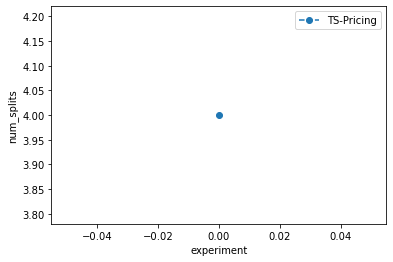

In [8]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_per_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_per_experiment.keys())
plt.show()

In [9]:
for key in context_split_per_experiment:
    print(f'{key}: avg splits -> {np.mean(context_split_per_experiment[key])}')

TS-Pricing: avg splits -> 4.0


In [10]:
val = days_of_split[ThompsonSampling.LEARNER_NAME]
avg_days = np.mean(val, axis=0)
val, avg_days

([[70, 80, 80]], array([70., 80., 80.]))

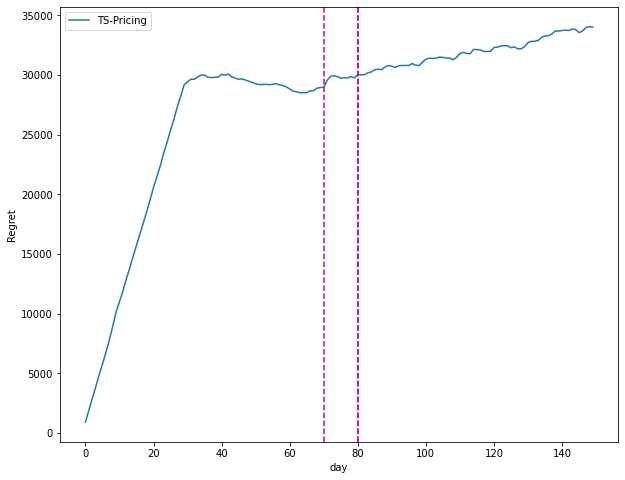

In [11]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(disaggr_opt - val, axis=0)))

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
for val in days_of_split.values():
    avg_days = np.mean(val, axis=0)
    for day in avg_days:
        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(rewards_per_experiment.keys())
plt.show()

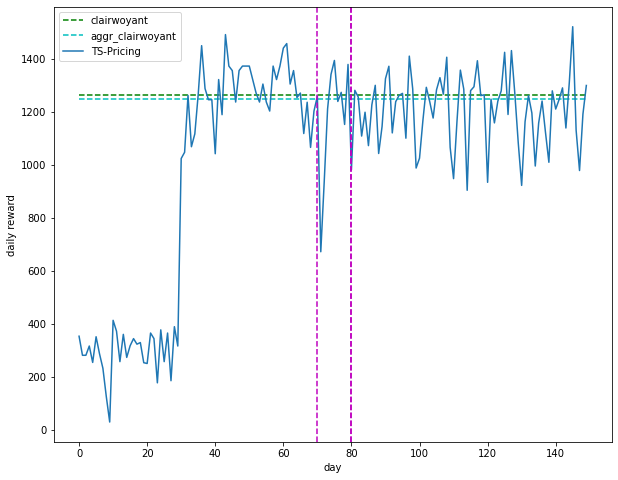

In [12]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
for val in days_of_split.values():
    avg_days = np.mean(val, axis=0)
    for day in avg_days:
        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(loc='best')
plt.show()